In [99]:
import pandas as pd

In [100]:
column_names = ['instance', 'cost', 'duration']

random = pd.read_csv('results_random_selection.log', sep=',', header=None, names=column_names)
roulette_wheel = pd.read_csv('results_roulettewheel_selection.log', sep=',', header=None, names=column_names)
neural = pd.read_csv('results_neural_softmax_selection.log', sep=',', header=None, names=column_names)

In [101]:
for df in [random, roulette_wheel, neural]:
    df['instance'] = df['instance'].apply(lambda x: str(x).split(":")[-1])

In [102]:
random_grouped = random.groupby('instance').agg({'cost':['min', 'mean'], 'duration':['mean', 'median']})
roulette_grouped = roulette_wheel.groupby('instance').agg({'cost':['min', 'mean'], 'duration':['mean', 'median']})
neural_grouped = neural.groupby('instance').agg({'cost':['min', 'mean'], 'duration':['mean', 'median']})

In [8]:
random_grouped.to_csv('results_random_selection.csv', index=True)
roulette_grouped.to_csv('results_roulette_selection.csv', index=True)
neural_grouped.to_csv('results_neural_softmax_selection.csv', index=True)

In [103]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

In [104]:
plt.style.use('default')

In [105]:
random_grouped = random_grouped[random_grouped.index.str[-5] != '8']
roulette_grouped = roulette_grouped[roulette_grouped.index.str[-5] != '8']
neural_grouped = neural_grouped[neural_grouped.index.str[-5] != '8']

In [106]:
random_grouped.index = random_grouped.index.str[:-6]
roulette_grouped.index = roulette_grouped.index.str[:-6]
neural_grouped.index = neural_grouped.index.str[:-6]

In [107]:
random_grouped['operator_selection'] = 'random'
roulette_grouped['operator_selection'] = 'roulette'
neural_grouped['operator_selection'] = 'neural'

In [108]:
df = pd.concat([random_grouped, roulette_grouped, neural_grouped])

In [109]:
df.columns = ['_'.join(filter(None, col)).strip() for col in df.columns.values]

In [110]:
df.columns

Index(['cost_min', 'cost_mean', 'duration_mean', 'duration_median',
       'operator_selection'],
      dtype='object')

In [111]:
instances = ["C1", "R1", "RC1", "C2", "R2", "RC2"]
instances_top = ["C1", "R1", "RC1"]
instances_bottom = ["C2", "R2", "RC2"]
operator_selection = ["random", "roulette", "neural"]

In [113]:
color_map = {
    "random": "#ccebc5",
    "roulette": "#b3cde3",
    "neural": "#fbb4ae"
}

In [116]:
def plot_boxplot(ax, instance):
    data_to_plot = []
    positions = []

    offsets = np.linspace(-0.3, 0.3, 3)  # Horizontal spacing between variants
    # Step 1: Find global min/max
    global_min = df['cost_mean'].min()
    global_max = df['cost_mean'].max()

    # Step 2: Round to nearest 100
    y_min = 100 * (global_min // 100)
    y_max = 100 * ((global_max + 99) // 100)

    for j, comp in enumerate(operator_selection):
        subset = df[(df.index == instance) & (df['operator_selection'] == comp)]
        data_to_plot.append(subset['cost_mean'].values)
        positions.append(0 + offsets[j])

    # Plot boxplot
    bp = ax.boxplot(data_to_plot, positions=positions, widths=0.15, patch_artist=True, manage_ticks=False, showfliers=False)

    # Assign colors to each box based on variant
    for i, box in enumerate(bp['boxes']):
        variant_index = i % 3
        comp_variant = operator_selection[variant_index]
        box.set_facecolor(color_map[comp_variant])

    # Set x-axis labels
    ax.set_xticks([])
    # Set uniform y-axis tick spacing (e.g., every 100 units)
    y_min, y_max = ax.get_ylim()
    tick_start = 100 * (int(y_min) // 100)
    tick_end = 100 * (int(y_max + 99) // 100)  # Ensures inclusion of max
    ax.set_yticks(np.arange(tick_start, tick_end + 1, 100))

    ax.set_title(instance)

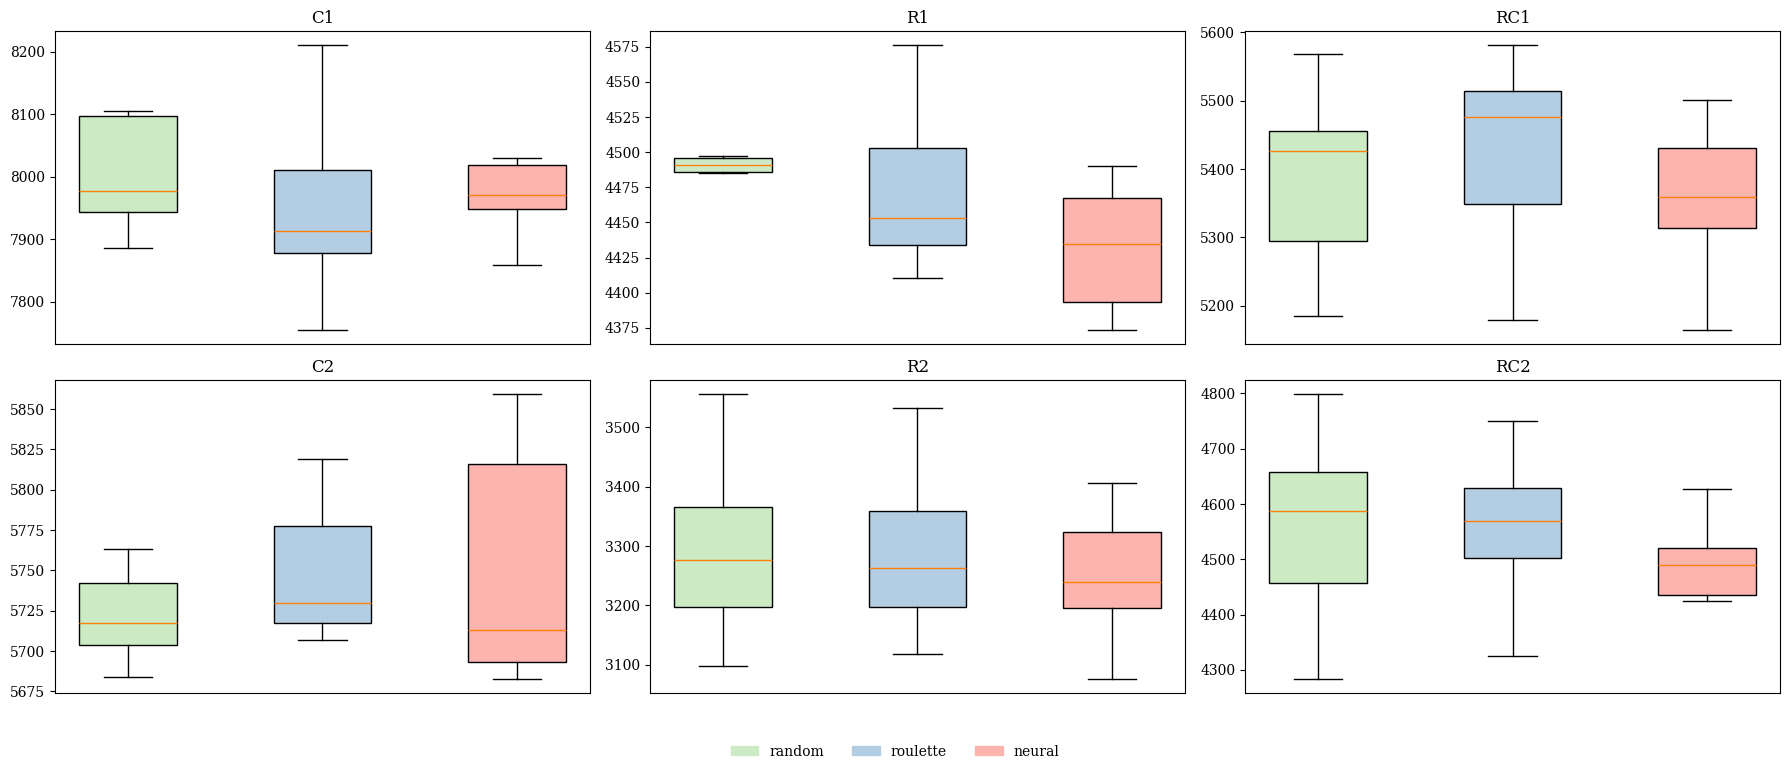

In [119]:
plt.rcParams["font.family"] = "serif"
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 8), sharey=False)
# Set figure and axes background to white
fig.patch.set_facecolor('white')
for ax in axes.flat:
    ax.set_facecolor('white')
# Iterate over instances and assign each to a subplot
for idx, instance in enumerate(instances):
    row = 0 if instance in instances_top else 1  # Assign top or bottom row
    col = instances_top.index(instance) if instance in instances_top else instances_bottom.index(
        instance)  # Column index
    plot_boxplot(axes[row, col], instance)

# Create a single legend for the entire figure
handles = [mpatches.Patch(color=color_map[comp], label=comp) for comp in operator_selection]
fig.legend(handles=handles, loc="lower center", edgecolor='black', ncol=3, frameon=False, bbox_to_anchor=(0.5, 0.03))

plt.tight_layout(rect=[0, 0.1, 1, 1])
plt.show()